# Loading Image Data

So far we've been working with fairly artificial datasets that you wouldn't typically be using in real projects. Instead, you'll likely be dealing with full-sized images like you'd get from smart phone cameras. In this notebook, we'll look at how to load images and use them to train neural networks.

We'll be using a [dataset of cat and dog photos](https://www.kaggle.com/c/dogs-vs-cats) available from Kaggle. Here are a couple example images:

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/assets/dog_cat.png?raw=1'>

We'll use this dataset to train a neural network that can differentiate between cats and dogs. These days it doesn't seem like a big accomplishment, but five years ago it was a serious challenge for computer vision systems.

In [201]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.nn.functional as F

import helper
import os
import numpy as np

import PIL
from PIL import Image
print(PIL.PILLOW_VERSION)

6.2.2


In [202]:
from google.colab import drive
drive.mount('/content/drive')

!ls -l "/content/drive/My Drive/checkpoints"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
total 1019698
-rw------- 1 root root  65984065 Jan 22 22:47 cat_dogs_densenet_121.pth
-rw------- 1 root root 489091900 Jan 21 22:47 cat_dogs_resnet152.pth
-rw------- 1 root root 489093553 Jan 22 21:48 cat_dogs_resnet152_v2.pth


The easiest way to load image data is with `datasets.ImageFolder` from `torchvision` ([documentation](http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder)). In general you'll use `ImageFolder` like so:

```python
dataset = datasets.ImageFolder('path/to/data', transform=transform)
```

where `'path/to/data'` is the file path to the data directory and `transform` is a list of processing steps built with the [`transforms`](http://pytorch.org/docs/master/torchvision/transforms.html) module from `torchvision`. ImageFolder expects the files and directories to be constructed like so:
```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

where each class has it's own directory (`cat` and `dog`) for the images. The images are then labeled with the class taken from the directory name. So here, the image `123.png` would be loaded with the class label `cat`. You can download the dataset already structured like this [from here](https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip). I've also split it into a training set and test set.

### Transforms

When you load in the data with `ImageFolder`, you'll need to define some transforms. For example, the images are different sizes but we'll need them to all be the same size for training. You can either resize them with `transforms.Resize()` or crop with `transforms.CenterCrop()`, `transforms.RandomResizedCrop()`, etc. We'll also need to convert the images to PyTorch tensors with `transforms.ToTensor()`. Typically you'll combine these transforms into a pipeline with `transforms.Compose()`, which accepts a list of transforms and runs them in sequence. It looks something like this to scale, then crop, then convert to a tensor:

```python
transform = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])

```

There are plenty of transforms available, I'll cover more in a bit and you can read through the [documentation](http://pytorch.org/docs/master/torchvision/transforms.html). 

### Data Loaders

With the `ImageFolder` loaded, you have to pass it to a [`DataLoader`](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader). The `DataLoader` takes a dataset (such as you would get from `ImageFolder`) and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.

```python
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
```

Here `dataloader` is a [generator](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/). To get data out of it, you need to loop through it or convert it to an iterator and call `next()`.

```python
# Looping through it, get a batch on each loop 
for images, labels in dataloader:
    pass

# Get one batch
images, labels = next(iter(dataloader))
```
 
>**Exercise:** Load images from the `Cat_Dog_data/train` folder, define a few transforms, then build the dataloader.

In [0]:
base_path = "./"
dataset_zip = "Cat_Dog_data.zip"
base_url = "https://s3.amazonaws.com/content.udacity-data.com/nd089/"

In [0]:
def download_dataset(base_path, base_url, dataset_zip):
  dir_name, _ = os.path.splitext(dataset_zip)
  if os.path.exists(dir_name):
    print("Data already exists at: {}".format(dir_name))
    return 

  fullpath = os.path.join(base_url, dataset_zip)
  !wget $fullpath
  !unzip -q $dataset_zip -d $base_path

In [205]:
download_dataset(base_path, base_url, dataset_zip)

Data already exists at: Cat_Dog_data


In [206]:
!ls Cat_Dog_data/*

Cat_Dog_data/test:
cat  dog

Cat_Dog_data/train:
cat  dog


In [0]:
data_dir = 'Cat_Dog_data'
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

In [0]:
transform = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])

dataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

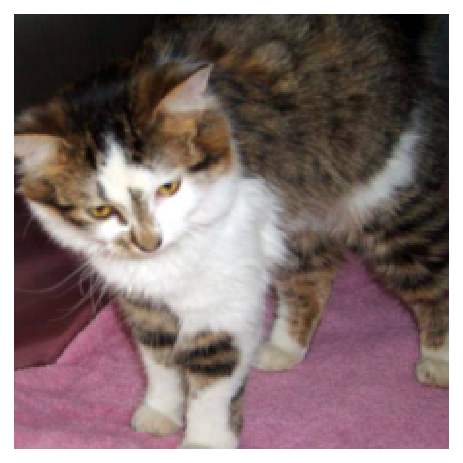

In [209]:
# Run this to test your data loader
images, labels = next(iter(dataloader))
helper.imshow(images[0], normalize=False)

If you loaded the data correctly, you should see something like this (your image will be different):

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/assets/cat_cropped.png?raw=1' width=244>

## Data Augmentation

A common strategy for training neural networks is to introduce randomness in the input data itself. For example, you can randomly rotate, mirror, scale, and/or crop your images during training. This will help your network generalize as it's seeing the same images but in different locations, with different sizes, in different orientations, etc.

To randomly rotate, scale and crop, then flip your images you would define your transforms like this:

```python
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])
```

You'll also typically want to normalize images with `transforms.Normalize`. You pass in a list of means and list of standard deviations, then the color channels are normalized like so

```input[channel] = (input[channel] - mean[channel]) / std[channel]```

Subtracting `mean` centers the data around zero and dividing by `std` squishes the values to be between -1 and 1. Normalizing helps keep the network work weights near zero which in turn makes backpropagation more stable. Without normalization, networks will tend to fail to learn.

You can find a list of all [the available transforms here](http://pytorch.org/docs/0.3.0/torchvision/transforms.html). When you're testing however, you'll want to use images that aren't altered (except you'll need to normalize the same way). So, for validation/test images, you'll typically just resize and crop.

>**Exercise:** Define transforms for training data and testing data below. Leave off normalization for now.

In [0]:
# Defininig the transforms for the training data and testing data
# Transforms ref: https://pytorch.org/docs/stable/torchvision/transforms.html
train_transforms = transforms.Compose([ transforms.RandomRotation(35), # Apply a random rotation of 35 degrees
                                       transforms.RandomResizedCrop(224), # Crop the given PIL Image to random size and aspect ratio.
                                       transforms.RandomGrayscale(p=0.05), # Apply random grayscale to the picture with a probability of 5%
                                       transforms.RandomHorizontalFlip(p=0.15), # Horizontal Flip Random with probability of 15%
                                       transforms.ToTensor(), # Transform to a Tensor
                                       transforms.Normalize([0.485, 0.456, 0.406],  # Normalize with the mean and std by each channel
                                                            [0.229, 0.224, 0.225])
                                       ])

test_transforms = train_transforms = transforms.Compose([ 
                                       transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor()
                                       ])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=256)

In [211]:
# change this to the trainloader or testloader 
data_iter = iter(testloader)

images, labels = next(data_iter)
print(images.shape)


torch.Size([256, 3, 224, 224])


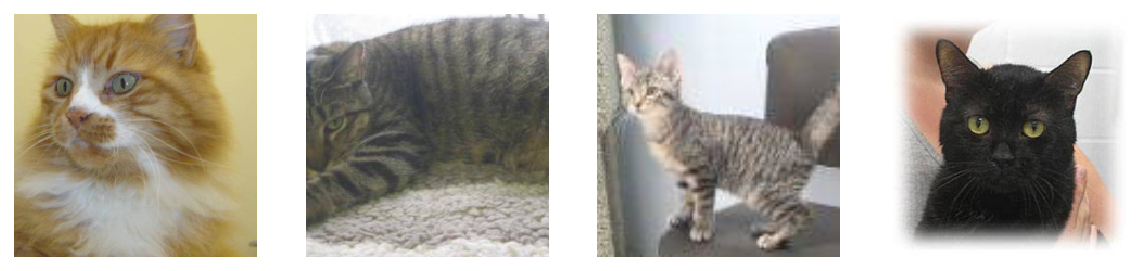

In [212]:
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=False)

Your transformed images should look something like this.

<center>Training examples:</center>
<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/assets/train_examples.png?raw=1' width=500px>

<center>Testing examples:</center>
<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/assets/test_examples.png?raw=1' width=500px>

At this point you should be able to load data for training and testing. Now, you should try building a network that can classify cats vs dogs. This is quite a bit more complicated than before with the MNIST and Fashion-MNIST datasets. To be honest, you probably won't get it to work with a fully-connected network, no matter how deep. These images have three color channels and at a higher resolution (so far you've seen 28x28 images which are tiny).

In the next part, I'll show you how to use a pre-trained network to build a model that can actually solve this problem.

In [0]:
def train_model(model, train_loader, test_loader, criterion, optimizer, device, epochs=5):
    '''
    train the model with accuracy and training / testing loss
    
    parameters
    ----------
    model: Classifier object to apply the trainining on.
    epochs: int, optional default: 30, number of iterations for training
    '''
    steps = 0
    print_every = 10
    # train_losses and test_losses to be used later for plotting 
    train_losses, test_losses = [], []
    for e in range(epochs):
        running_loss = 0
       
        for images, labels in train_loader:
            steps +=1
            # Move images and labels tensors to the default device
            images, labels = images.to(device), labels.to(device)
          
            # Refresh the gradients to zero 
            optimizer.zero_grad()

            # Forward pass
            log_ps = model.forward(images)
            # Calculate loss function 
            loss = criterion(log_ps, labels)
            # Propagate the loss
            loss.backward()

            # Update the weights 
            optimizer.step()

            running_loss += loss.item() 
            
            if steps % print_every == 0:
              print("Validation step: {}".format(steps))
              test_loss = 0 
              accuracy = 0 
              ## Validation pass
              with torch.no_grad(): # Don't use the gradients
                  model.eval()
                  for images, labels in test_loader: # Use the test data
                    
                      # Move images and labels tensors to the default device
                      images, labels = images.to(device), labels.to(device)
                      
                      # forward pass 
                      out = model.forward(images)
                      # calculate the test loss
                      test_loss += criterion(out, labels)
                      # Calculate the probabilities
                      probabilities = torch.exp(out)
                      # Calculate the top 1 class
                      top_p, top_class = probabilities.topk(1, dim=1)
                      # Compare the top class against the actual labels
                      equals = top_class == labels.view(*top_class.shape)
                      # Calculate accuracy
                      tensorType = torch.FloatTensor if device == 'cpu' else torch.cuda.FloatTensor 
                      accuracy += torch.mean(equals.type(tensorType))
              
              model.train() 
              train_losses.append(running_loss / len(train_loader))
              test_losses.append(test_loss / len(test_loader))

              print("Epoch: {}/{}.. ".format(e+1, epochs),
                    "Training Loss: {:.5f}.. ".format(train_losses[-1]),
                    "Test Loss: {:.5f}.. ".format(test_losses[-1]),
                    "Test Accuracy: {:.3f}".format((accuracy/len(test_loader))*100))
    return model, optimizer,  train_losses, test_losses

In [0]:
"""
 Ideally we want to build a model that looks like this :) 
 But even with that, our model might not perform really well. 
 Instead we could start using Transfer Learning. We take a model that has 
 been trained already and modify the last layer to adjust it as we wish. 
"""
class CatDogClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_layer = nn.Linear(150528, 1024)
    self.hid_layer_1 = nn.Linear(1024, 512)
    self.hid_layer_2 = nn.Linear(512,256)
    self.hid_layer_3 = nn.Linear(256, 64)
    self.out = nn.Linear(64,2)

    self.dropout = nn.Dropout(p=0.5)

  def forward(self,x):

    x = x.view(x.shape[0],-1)

    x = self.dropout(F.relu(self.input_layer(x)))
    x = self.dropout(F.relu(self.hid_layer_1(x)))
    x = self.dropout(F.relu(self.hid_layer_2(x)))
    x = self.dropout(F.relu(self.hid_layer_3(x)))
    x = self.out(x)

    return x

In [215]:
# Transfer Learning. Using a pretrained model. In this case DenseNet 121
model = models.densenet121(pretrained=True)
# Check out the last layer, identified as "classifier"
model.classifier

Linear(in_features=1024, out_features=1000, bias=True)

In [0]:
# Freeze parameters :) 
for param in model.parameters():
    param.requires_grad = False

In [0]:
from collections import OrderedDict

# Define the CatDogClassifier network to be used as the last layer of the resnet model
cat_dog_classifier = nn.Sequential(OrderedDict([
                          ('input_layer', nn.Linear(1024, 512)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(p=0.20)),
                          ('hidden_layer', nn.Linear(512, 256 )),
                          ('relu', nn.ReLU()),
                          ('dropout_2', nn.Dropout(p=0.20)),
                          ('last_layer', nn.Linear(256, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

In [218]:
# Update the model 
model.classifier = cat_dog_classifier # replace the last layer with the layers defined by your own model
# Define the loss function 
criterion = nn.CrossEntropyLoss()
# Define the optimizer to be used for updating the weights
optimizer = optim.SGD(model.classifier.parameters(),lr=0.001)
# Last layer will look like this 
model.classifier

Sequential(
  (input_layer): Linear(in_features=1024, out_features=512, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (hidden_layer): Linear(in_features=512, out_features=256, bias=True)
  (dropout_2): Dropout(p=0.2, inplace=False)
  (last_layer): Linear(in_features=256, out_features=2, bias=True)
  (output): LogSoftmax()
)

In [219]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on {}".format(device))
model.to(device);

Running on cuda


In [0]:
import math

In [0]:
'''
Validate the trainloader size against what is on the train folder

1.- Calculate the trainloader size 
2.- Count the amount of images on the train folder, for all clases 
3.- Set the batch size 
4.- Assert that the dataset size divided by the batch size (32) is the same as the trainloader size 
'''
trainloader_size = len(trainloader) 
dataset_size = !ls ./Cat_Dog_data/train/*/* | wc -l 
batch_size = 256
assert math.ceil(int(dataset_size[0])/ batch_size) == trainloader_size

In [222]:
# Uncomment if you want to train the model ( last layer only - classifier) for 2 epochs
modelTrained, optimizer, train_loss, test_loss = train_model(model, trainloader, testloader, criterion, optimizer, device, epochs=2)

Validation step: 10
Epoch: 1/2..  Training Loss: 0.07975..  Test Loss: 0.70203..  Test Accuracy: 45.297
Validation step: 20
Epoch: 1/2..  Training Loss: 0.15800..  Test Loss: 0.68861..  Test Accuracy: 55.088
Validation step: 30
Epoch: 1/2..  Training Loss: 0.23545..  Test Loss: 0.67749..  Test Accuracy: 61.229
Validation step: 40
Epoch: 1/2..  Training Loss: 0.31203..  Test Loss: 0.66868..  Test Accuracy: 65.685
Validation step: 50
Epoch: 1/2..  Training Loss: 0.38767..  Test Loss: 0.66032..  Test Accuracy: 71.363
Validation step: 60
Epoch: 1/2..  Training Loss: 0.46221..  Test Loss: 0.65258..  Test Accuracy: 75.146
Validation step: 70
Epoch: 1/2..  Training Loss: 0.53605..  Test Loss: 0.64362..  Test Accuracy: 79.274
Validation step: 80
Epoch: 1/2..  Training Loss: 0.60903..  Test Loss: 0.63498..  Test Accuracy: 81.806
Validation step: 90
Epoch: 2/2..  Training Loss: 0.01443..  Test Loss: 0.62674..  Test Accuracy: 85.549
Validation step: 100
Epoch: 2/2..  Training Loss: 0.08556..  Tes

In [0]:
checkpoint_name = "/content/drive/My Drive/checkpoints/cat_dogs_densenet_121_v2.pth"

In [0]:
def save_model(model, optimizer, checkpoint_name):
  '''
  save_model will create the checkpoint dictionary and save the model to a file

  parameters
  ----------
  model, pytorch trained model
  checkpoint_name: string, fullpath to where the checkpoint will be stored
  '''

  # Define the checkpoint to be able to load the model later :) 
  # Save the state_dict, input and output size, optimizer state
  # Last Layer, and Architecture you trained on. 
  # Note: checkpoint dict should be modified accordingly to the model you are using
  checkpoint = {'input_size': 1024,
                'output_size': 2,
                'hidden_layer': 256,
                'last_layer': 2,
                'epochs': 2,
                'batch_size': 256,
                'optimizer_state': optimizer.state_dict(),
                'classifier': model.classifier,
                'architecture': models.densenet121(pretrained=True),
                'state_dict': model.state_dict()}
                
  torch.save(checkpoint,checkpoint_name)

In [0]:
def load_checkpoint(filepath):
    '''
    load_checkpoint, will load the model from a checkpoint file

    parameters
    ---------
    filepath: string, fullpath to read the checkpoint file.

    returns
    -------
    torch model
    '''
    checkpoint = torch.load(filepath) # Load the model
    model = checkpoint['architecture'] # Load the architecture
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    epochs = checkpoint['epochs'] # Load the epochs you trained on 
    model.classifier = checkpoint['classifier'] # Override the last layer

    return model



In [230]:
save_model(modelTrained, optimizer, checkpoint_name)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist

In [231]:
model_cat_dogs = load_checkpoint(checkpoint_name)
model_cat_dogs.classifier

Sequential(
  (input_layer): Linear(in_features=1024, out_features=512, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (hidden_layer): Linear(in_features=512, out_features=256, bias=True)
  (dropout_2): Dropout(p=0.2, inplace=False)
  (last_layer): Linear(in_features=256, out_features=2, bias=True)
  (output): LogSoftmax()
)

In [0]:
def update_labels(classes):
  labels = []
  cat_to_name = {'0': 'cat', '1': 'dog'}
  for x in classes.cpu().numpy().squeeze():
    labels.append(cat_to_name[str(x)])
  
  return labels

In [0]:
def process_image(img_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    img = Image.open(img_path)
    
    transform = transforms.Compose([  transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],  
                                                           [0.229, 0.224, 0.225])])
    image_tensor = transform(img)
    
    return image_tensor

## Testing your Model

On this section you will: 

- Upload some pictures :) 
- Process the image by processing it using Transforms 
- Make a prediction using the trained model 
- Validate your prediction by displaying the picture and it's probabilities class.

In [0]:
def predict(image_path, model, topk=2):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.cuda()
    # let us process the image 
    img = process_image(image_path)
    # Convert 2D image to 1D vector
    image = img.unsqueeze_(0)

    # Calculate the class probabilities (softmax) for img
    with torch.no_grad():
      model.eval()
      output = model.forward(image.cuda())
      possibilities, predicted = torch.topk(output, topk)
      
    ps = F.softmax(possibilities,dim=1)
    
    return ps, predicted

In [0]:
def check(img, probs, classes):
    probs = probs.data.numpy().squeeze()
    img = Image.open(img)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(np.arange(2), probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(2))
    ax2.set_yticklabels(update_labels(classes), size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)



    plt.tight_layout()

In [253]:
from google.colab import files

uploaded=files.upload()

Saving cat.991.jpg to cat.991.jpg


In [254]:
img_path = list(uploaded.keys())[0]
img = process_image(img_path)
print(img.shape)

torch.Size([3, 224, 224])


In [255]:
probs, preds = predict(img_path,model_cat_dogs)
probs, preds

(tensor([[0.6492, 0.3508]], device='cuda:0'),
 tensor([[0, 1]], device='cuda:0'))

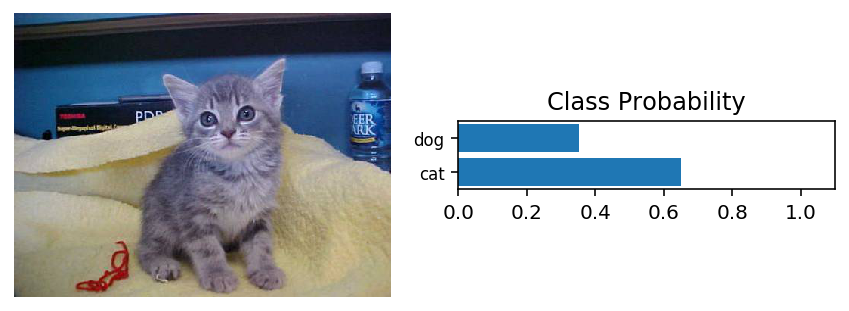

In [256]:
check(img_path, probs.cpu(), preds.cpu())